## Introduction

Fetching similar images in (near) real time is an important use-case in information retrieval systems. Some popular examples utilizing this include Pinterest, Google Image Search, etc. In this example, we will build a similar image parsing utility using [Locality Sensitive Hashing](https://towardsdatascience.com/understanding-locality-sensitive-hashing-49f6d1f6134) (LSH) and [Random Projection](https://en.wikipedia.org/wiki/Random_projection) on top of a pre-trained image classifier. We will also look into optimizing the performance of our parser given a commodity GPU-based environment. These kinds of parsers are also known as _near duplicate (or near-dup) image detectors_. 

There are other examples in [keras.io/examples/vision](https://keras.io/examples/vision) that are worth checking out in this regard:

* [Metric learning for image similarity search](https://keras.io/examples/vision/metric_learning)
* [Image similarity estimation using a Siamese Network with a triplet loss](https://keras.io/examples/vision/siamese_network)

Finally, this example uses the following resource as a reference and as such reuses code from there: [Locality Sensitive Hashing for Similar Item Search](https://towardsdatascience.com/locality-sensitive-hashing-for-music-search-f2f1940ace23).

_Note that in order to optimize the performance of our parser, you should be connected to a GPU._

GPU: P100. 

## Imports

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

## Load dataset and create a training set of 1000 images

To keep the runtime of the example short, we will be using a subset of 1000 images from the `tf_flowers` dataset (available through [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/tf_flowers)) to build our vocabulary. 

In [ ]:
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

In [ ]:
IMAGE_SIZE
NUM_IMAGES = 1000

images = []
labels = []

for (image, label) in train_ds.take(NUM_IMAGES):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    images.append(image.numpy())
    labels.append(label.numpy())

images = np.array(images)
labels = np.array(labels)

## Pre-trained model

In this section, we load our image classification model that was trained on the `tf_flowers` dataset. 85% of the total images were used to build the training set. For more details on the training, you check out [this notebook](TODO).

The underlying model is a BiT-ResNet (proposed in [Big Transfer (BiT): General Visual Representation Learning](https://arxiv.org/abs/1912.11370)). BiT-ResNet family of models are known to have excellent transfer performance across a wide variety of different downstream tasks. 

In [ ]:
!gdown --id 19VxuBZyn9BUedwRCZRsXQ0-1HFbF7x3u
!tar xf flower_model_bit_0.96875.gz

In [ ]:
bit_model = tf.keras.models.load_model("flower_model_bit_0.96875")
bit_model.count_params()

23510597

## Create an embedding model

To parse the similar images given a query image, we need to first generate vector representations of the images. For this purpose, we will be branching the above image classifier such that it becomes apt for our purpose. 

In [ ]:
embedding_model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3)),
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1.0 / 255),
        bit_model.layers[1],
        tf.keras.layers.Lambda(tf.math.l2_normalize),
    ],
    name="embedding_model",
)

embedding_model.summary()

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23500352  
_________________________________________________________________
lambda (Lambda)              (None, 2048)              0         
Total params: 23,500,352
Trainable params: 23,500,352
Non-trainable params: 0
_________________________________________________________________


Take note of the normalization layer inside the model. It is used to project the representation vectors to the space of unit-spheres.

## Hashing utilities

In [ ]:
def hash_func(embedding, random_vectors):
    if not isinstance(embedding, np.ndarray):
        embedding = embedding.numpy()

    # Random projection.
    bools = np.dot(embedding, random_vectors) > 0
    return [bool2int(bool_vec) for bool_vec in bools]


def bool2int(x):
    y = 0
    for i, j in enumerate(x):
        if j:
            y += 1 << i
    return y

The dimensionality coming out of `embedding_model` is (2048,) and considering practical aspects (storage, retrieval performance, etc.) it is quite large. So, there arises a need to reduce this dimensionality without reducing the information content. This is where Random Projections come into the picture. It is based on the principle that if the distance between a group of points on a given plane is _approximately_ preserved the dimensionality of that plane can further be reduced. 

Inside `hash_func()`, we first reduce the dimensionality of the embedding vectors. Then we compute the bitwise hash values of the images to determine their hash buckets. Images having same hash values are likely to go into the same hash bucket. From a deployment perspective, bitwise hash values are cheaper to store and operate on.

## LSH builders

The `Table` class is responsible for building a single hash table. Each entry in the hash table is a mapping between the reduced embedding of an image from our dataset and a unique identifier. Because our dimensionality reduction technique involves randomness, it can so happen that similar images are not mapped to the same hash bucket everytime the process run. So, to reduce this effect, we will take results from multiple tables into consideration. So, the number of tables and the reduction dimensionality are the key hyperparameters here. 

In [ ]:
class Table:
    def __init__(self, hash_size, dim):
        self.table = dict()
        self.hash_size = hash_size
        self.random_vectors = np.random.randn(hash_size, dim).T

    def add(self, id, vecs, label):
        # Create a unique indentifier.
        entry = {"id_label": str(id) + "_" + str(label)}

        # Compute the hash values.
        hashes = hash_func(vecs, self.projections)

        # Add the hash values to the current table.
        for h in hashes:
            if h in self.table:
                self.table[h].append(entry)
            else:
                self.table[h] = [entry]

    def query(self, vecs):
        # Compute hash value for the query vector.
        hashes = hash_func(vecs, self.random_vectors)
        results = list()

        # Loop over the query hashes and determine if they exist in
        # the current table.
        for h in hashes:
            if h in self.table:
                results.extend(self.table[h])
        return results

In [ ]:
class LSH:
    def __init__(self, hash_size, dim, num_tables):
        self.num_tables = num_tables
        self.tables = list()
        for i in range(self.num_tables):
            self.tables.append(Table(hash_size, dim))

    def add(self, id, vecs, label):
        for table in self.tables:
            table.add(id, vecs, label)

    def query(self, vecs):
        results = list()
        for table in self.tables:
            results.extend(table.query(vecs))
        return results

We will encapsulate the logic for building and operating with the master LSH table inside a class. It has two methods:

* `train()`: Responsible for building the final LSH table. 
* `query()`: Calculates the number of matches given a query image and also quantifies the similarity score.

In [ ]:
class BuildLSHTable:
    def __init__(
        self, embedding_model, concrete_function, hash_size=8, dim=2048, num_tables=10
    ):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.dim, self.num_tables)

        self.embedding_model = embedding_model
        self.concrete_function = concrete_function

    def train(self, training_files):
        for id, training_file in enumerate(training_files):
            # Unpack the tuple.
            image, label = training_file
            if len(image.shape) < 4:
                image = image[None, ...]

            # Compute embeddings and update the LSH tables.
            # More on `self.concrete_function()` later.
            if self.concrete_function:
                features = self.concrete_function(tf.constant(image))["lambda"].numpy()
            else:
                features = self.embedding_model.predict(image)
            self.lsh.add(id, features, label)

    def query(self, image):
        # Compute the embeddings of the query image and fetch the results.
        if len(image.shape) < 4:
            image = image[None, ...]

        if self.concrete_function:
            features = self.concrete_function(tf.constant(image))["lambda"].numpy()
        else:
            features = self.embedding_model.predict(image)

        results = self.lsh.query(features)
        print("Matches:", len(results))

        # Calculate Jaccard index to quantify the similarity.
        counts = dict()
        for r in results:
            if r["id_label"] in counts:
                counts[r["id_label"]] += 1
            else:
                counts[r["id_label"]] = 1
        for k in counts:
            counts[k] = float(counts[k]) / self.dim
        return counts

## Create LSH tables

With our helper utilities and classes implemented, we can now build our LSH table.

In [ ]:
training_files = zip(images, labels)
lsh_builder = BuildLSHTable(embedding_model)

## Optimizing the model with TensorRT

In [ ]:
embedding_model.save("embedding_model")

params = tf.experimental.tensorrt.ConversionParams(
    precision_mode="FP16",
    maximum_cached_engines=16)
converter = tf.experimental.tensorrt.Converter(
    input_saved_model_dir="embedding_model", conversion_params=params)
converter.convert()
converter.save("tensorrt_embedding_model")  

INFO:tensorflow:Assets written to: embedding_model/assets


INFO:tensorflow:Assets written to: embedding_model/assets


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)


INFO:tensorflow:Assets written to: tensorrt_embedding_model/assets


INFO:tensorflow:Assets written to: tensorrt_embedding_model/assets


In [ ]:
root = tf.saved_model.load("tensorrt_embedding_model") 
concrete_func = root.signatures["serving_default"]

CPU times: user 21.8 s, sys: 1 s, total: 22.8 s
Wall time: 22.5 s


We need to rewrite our `BuildLSHTable` to support the use of [concrete functions](https://www.tensorflow.org/guide/intro_to_graphs). 

In [ ]:
class BuildLSHTableTRT:
    def __init__(self, hash_size=8, dim=2048, num_tables=10):
        self.hash_size = hash_size
        self.dim = dim
        self.num_tables = num_tables
        self.lsh = LSH(self.hash_size, self.dim, self.num_tables)
        self.concrete_function = concrete_func

    def train(self, training_files):
        for id, training_file in enumerate(training_files):
            image, label = training_file
            if len(image.shape) < 4:
                image = image[None, ...]
            features = self.concrete_function(tf.constant(image))["lambda"]
            self.lsh.add(id, features.numpy(), label)
        
    def query(self, image):
        if len(image.shape) < 4:
            image = image[None, ...]
        features = self.concrete_function(tf.constant(image))["lambda"].numpy()
        results = self.lsh.query(features)
        print("Matches:", len(results))

        # Jaccard index
        counts = dict()
        for r in results:
            if  r["id_label"] in counts:
                counts[r['id_label']] += 1
            else:
                counts[r['id_label']] = 1
        for k in counts:
            counts[k] = float(counts[k])/self.dim
        return counts

In [ ]:
training_files = zip(images, labels)
lsh_builder_trt = BuildLSHTableTRT()
%time lsh_builder_trt.train(training_files)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function gaussian_random_matrix is deprecated; gaussian_random_matrix is deprecated in 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


CPU times: user 13.6 s, sys: 10.7 s, total: 24.3 s
Wall time: 12 s


The benefits of using TensorRT when using GPUs are clear (notice the wall time, previously it was **46.9 s**). 

## Validation

In [ ]:
validation_images = []
validation_labels = []

for image, label in validation_ds.take(100):
    image = tf.image.resize(image, (224, 224))
    validation_images.append(image.numpy())
    validation_labels.append(label.numpy())

validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)
validation_images.shape, validation_labels.shape

((100, 224, 224, 3), (100,))

In [ ]:
def plot_images(images, labels):
    plt.figure(figsize=(20, 10))
    columns = 5
    for (i, image) in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(labels[i]))
        else:
            ax.set_title("Similar Image # " + str(i) +
                         "\nLabel: {}".format(labels[i]))
        plt.imshow(image.astype("int"))
        plt.axis("off")

In [ ]:
def visualize_lsh(lsh_class):
    idx = np.random.choice(len(validation_images))
    image = validation_images[idx]
    label = validation_labels[idx]
    results = lsh_class.query(image)

    candidates = []
    labels = []
    overlaps = []

    for idx, r in enumerate(sorted(results, key=results.get, reverse=True)):
        if idx == 4:
            break
        image_id, label = r.split("_")[0], r.split("_")[1]
        print(image_id)
        candidates.append(images[int(image_id)])
        labels.append(label)
        overlaps.append(results[r])

    candidates.insert(0, image)
    labels.insert(0, label)

    plot_images(candidates, labels)

### Non-TRT model

Matches: 230
27
566
712
703


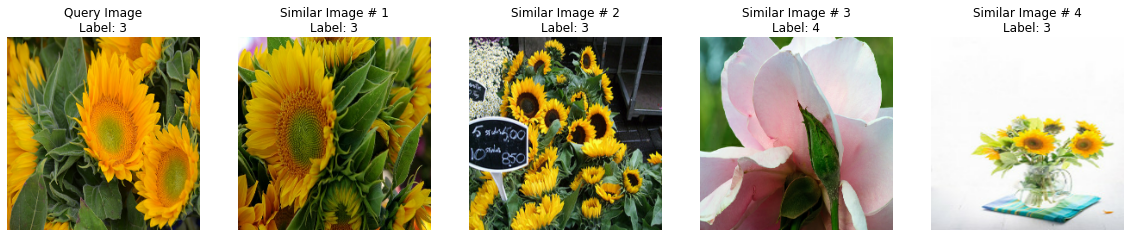

In [ ]:
visualize_lsh(lsh_builder)

Matches: 130
146
461
44
97


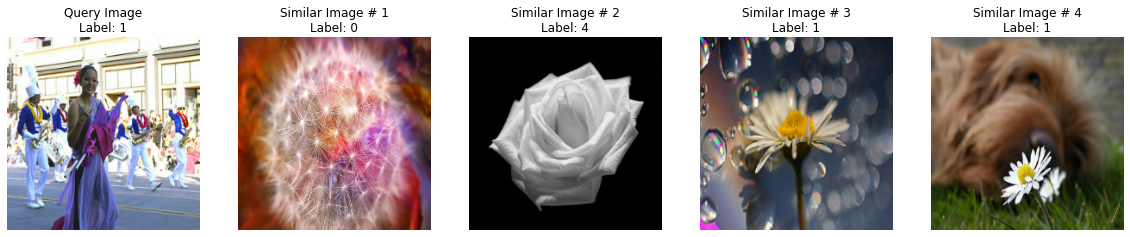

In [ ]:
visualize_lsh(lsh_builder)

### TRT model

Matches: 553
77
165
556
606


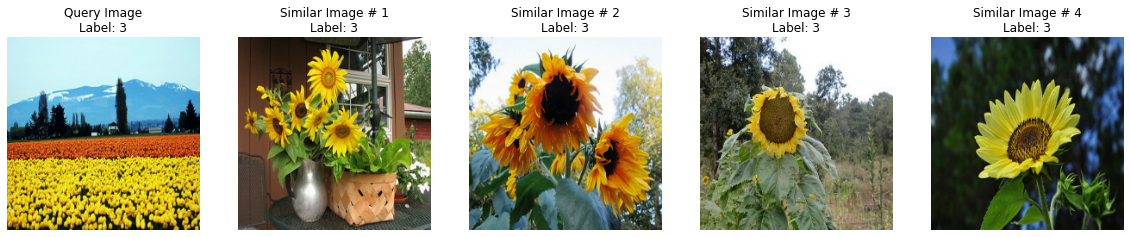

In [ ]:
visualize_lsh(lsh_builder_trt)

Matches: 670
978
85
88
357


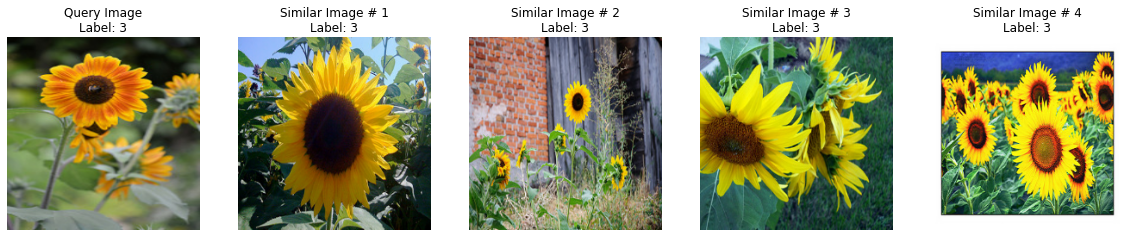

In [ ]:
visualize_lsh(lsh_builder_trt)

## Benchmarking query results

In [ ]:
def benchmark(lsh_class):
    start_time = time.time()
    for _ in range(1000):
        image = np.ones((1, 224, 224, 3)).astype("float32")
        _ = lsh_class.query(image)
    end_time = time.time() - start_time
    print(f"Time taken: {end_time:.3f}")

In [ ]:
benchmark(lsh_builder)

Time taken: 49.553 seconds.

In [ ]:
benchmark(lsh_builder_trt)

Time taken: 13.152 seconds. 